In [2]:
# imports from custom library
import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Linear Supervised Learning Series

# Part 6: Linear multi-class classification

Here we discuss a popular alternative to OvA multi-class classification where we also learn $C$ two-class classifiers (and also employ the fusion rule) but train them *simultaneously* instead of independently as with OvA.

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# 1.  Multi-class perceptron and logistic regression

## 1.1 The multi-class perceptron

As with OvA, we deal with an arbitrary multi-class dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consisting of $C$ distinct classes of data with label values $y_{p}\in\left\{ 1,2,...,C\right\} $.  

Recall: the fusion rule gives us predicted labels for our dataset, the $p^{th}$ of which $\hat y_p$ given as

\begin{equation}
\hat y_p =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}
\end{equation}

Also recall: the normal vectors here are assumed to all have unit length, i.e., $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j$.

For the $p^{th}$ point, ideally we want this prediction to match its true label, i.e., $\hat y_p = y_p$, so that we have

\begin{equation}
w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}
\end{equation}

Remember geometrically this simply says that the (signed) distance from the point $\mathbf{x}_p$ to its class decision boundary is greater than its distance from every other class's.

Subtracting $ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}$ from both sides we have

\begin{equation}
\left(\underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) = 0
\end{equation}

\begin{equation}
\left(\underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) = 0
\end{equation}

Ideally, we want this to be true for every $\mathbf{x}_p$. But regardless, we always have that

\begin{equation}
\left(\underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \geq 0
\end{equation}

AHA: summing up the expression above should give a proper cost function to minimimize in order to find optimal classifer weights.  

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = \sum_{p = 1}^P \left[\,\left(\underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]
\end{equation}

 - This is called the **multi-class perceptron cost**

- This cost is a direct generalization of the two-class perceptron, and reduces to it when $C=2$. 

- Like the two-class perceptron, this cost is also convex.  

**Note:** in minimizing the perceptron cost we should - at least formally - subject it to the constraints that all normal vectors are unit length

\begin{equation}
\begin{aligned}
\underset{w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,...,\,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}}{\,\,\,\,\,\,\,\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \sum_{p = 1}^P \left[\,\left(\underset{j=1,...,C} {\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]\\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1, \,\,\,\,\,\, j=1,...,C
\end{aligned}
\end{equation}

- This *constrained* optimization problem can be solved directly via, e.g., projected gradient descent.

- However it is more commonplace to see this problem approximately solved by *relaxing the constraints*.

The unconstrained *regularized* form of multi-class perceptron 

\begin{equation}
\underset{w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}}{\text{minimize}} \,\, \sum_{p = 1}^P \left[\,\left(\underset{j=1,...,C} {\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right] + \lambda \sum_{j = 1}^{C} \left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 
\end{equation}

- The unconstrained form is convex. 

- It does not quite match the original constrained formulation as regularizing all normal vectors together will not necessarily guarantee that $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j$.

- Nonetheless it will generally force the length of all normal vectors to behave well, e.g., disallowing one normal vector to grow arbitrarily large while one shrinks to almost nothing.

- $\lambda$ typically set to a small value, e.g., $10^{-3}$ or smaller.

#### <span style="color:#a50e3e;">Example 1: </span> Multi-class perceptron

In this example we employ unnormalized gradient descent to minimize the regularized multi-class classifier defined above over a toy dataset with $C=3$ classes used previously in deriving OvA.

<IPython.core.display.Javascript object>


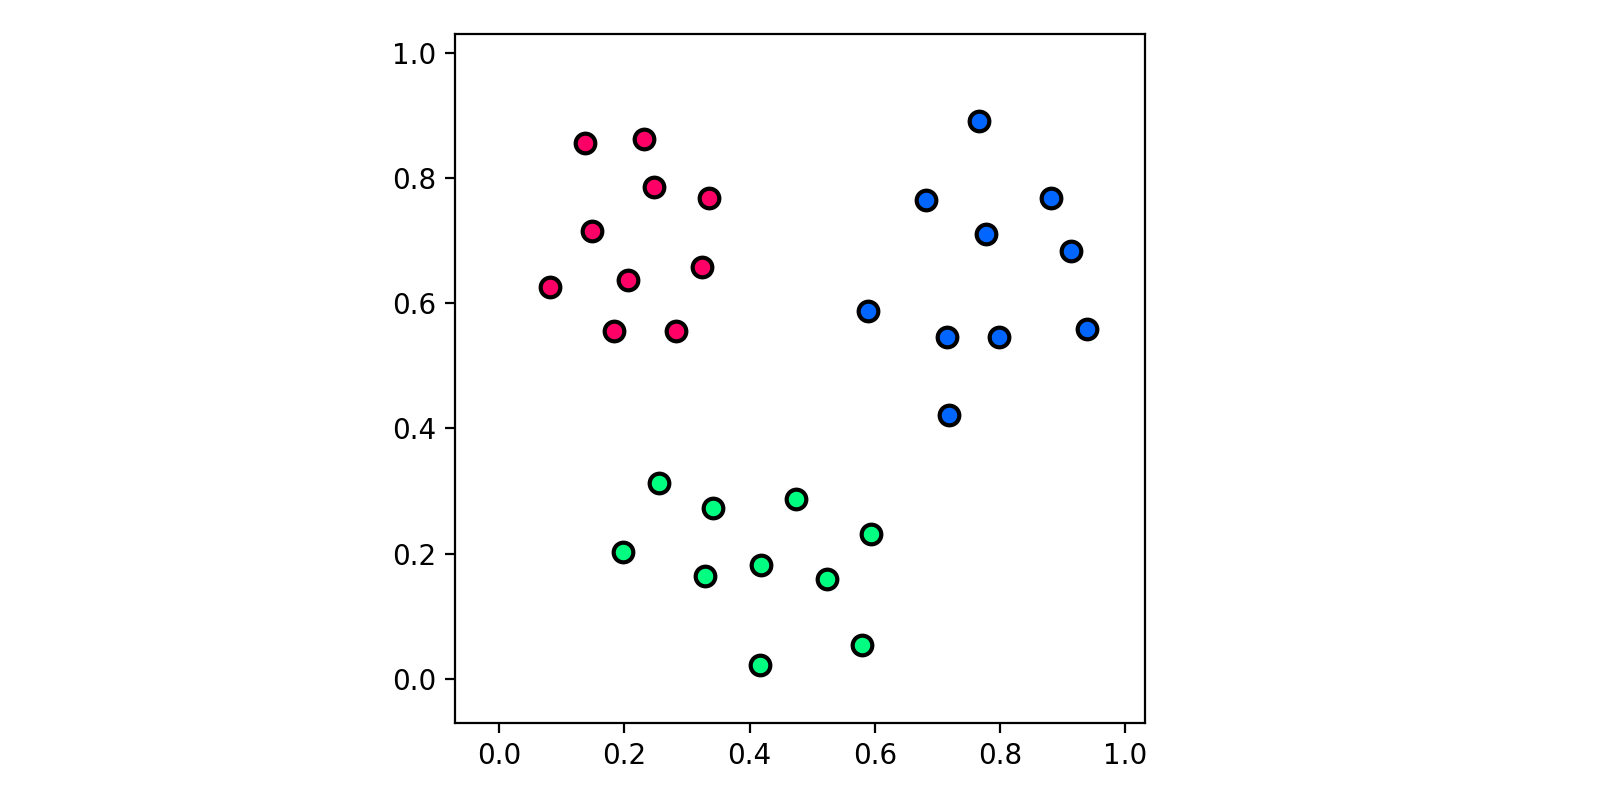

In [18]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

One is free to implement the cost function here in a number of ways.  Note however that in the particular implementation shown here the weights from all $C$ classifiers are input as an $N + 1$ by $C$ array of the form

\begin{equation}
\mathbf{W}=\left[\begin{array}{cccc}
w_{0}^{(1)} & w_{0}^{(2)} & \cdots & w_{0}^{(C)}\\
\mathbf{w}^{(1)} & \mathbf{w}^{(2)} & \cdots & \mathbf{w}^{(C)}
\end{array}\right]
\end{equation}

where the bias and normal vector of the $c^{th}$ classifier have been stacked on top of one another and made the array's $c^{th}$ column.  Also note that the quantity $w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}$ is pre-computed for all points prior to the summation and stored in a single array.

In [20]:
# multiclass perceptron regularized by the summed length of all normal vectors
lam = 10**-4  # our regularization paramter 
def multiclass_perceptron(W):        
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x.T,W[1:,:])

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = int(y[p][0]) - 1    # subtract off one due to python indexing

        # update cost summand
        cost +=  max(all_evals[p,:]) - all_evals[p,y_p]
        
        # return cost with regularizer added
    return cost + lam*np.linalg.norm(W[1:,:],'fro')**2

In [31]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,4)
w_hist = opt.gradient_descent(g = multiclass_perceptron,w = W_init,version = 'unnormalized',max_its = 200, alpha = 10**-2)

<IPython.core.display.Javascript object>


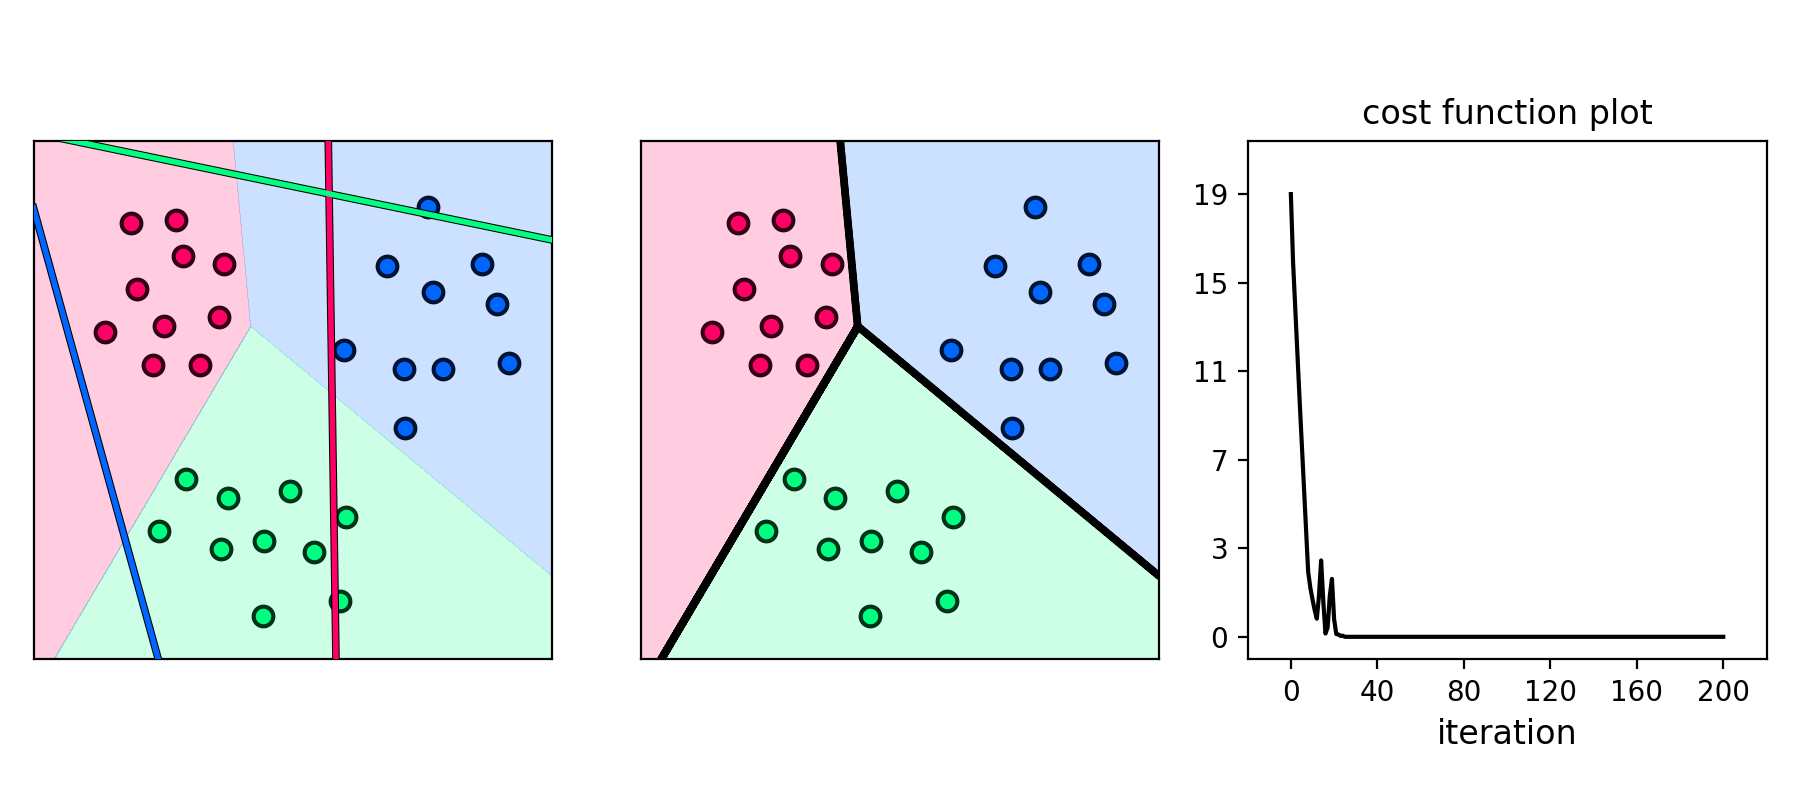

In [32]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(w_hist,show_cost = True, cost = multiclass_perceptron)

## 1.2  The smooth softmax approximation to multi-class perceptron cost

Recall that the *softmax function*

\begin{equation}
\text{soft}\left(s_{1},...,s_{C}\right)=\text{log}\left(\sum_{j = 1}^{C} e^{s_{j}}\right)
\end{equation}

is a close and smooth approximation to the maximum of $C$ scalar numbers $s_{1},...,s_{C}$, i.e.,

\begin{equation}
\text{max}\left(s_{1},...,s_{C}\right) \approx \text{soft}\left(s_{1},...,s_{C}\right)
\end{equation}

Lets replace the max function with softmax in each summand of the multi-class perceptron cost

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = \sum_{p = 1}^P \left[\,\left(\underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]
\end{equation}

This is what we get:

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = \sum_{p = 1}^P \left[\text{log}\left( \sum_{j = 1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}  \right) - \left( w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right)\right]
\end{equation}

- This is called **the multi-class softmax cost**

- It also reduces to the two-class version when $C = 2$

- It is not only convex but - unlike the multi-class perceptron - it has infinitely many smooth derivatives, hence we can use Newton's method (in addition to gradient descent) to minimize it.

The multi-class sostmax cost goes by many names - e.g., **softmax regression** and **multi-class logistic regression** 

Sometimes it is more convenient to write it equivalently - using basic properties of the log function - as 

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = -\sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }{ \sum_{j = 1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}} }\right)
\end{equation}

### Implementation warning

- Care must be taken when implementing any cost function - or mathematical expression in general - involving the exponential function $e^{\left(\cdot\right)}$ in Python.

- By nature the exponential function grows large very rapidly causing undesired 'overflow' issues even with moderate-sized exponents, e.g., $e^{1000}$. Large numbers like this cannot be stored explicitly on the computer and so are represented symbolically as $\infty$. 

- Additionally, the division of two such large numbers - which is a potentiality when evaluating the summands of the multi-class cost in equation (12) - is computed and stored as a NaN (not a number) causing severe numerical stability issues. 

### Ways to fix it

- Normalizing the data - to fall within a relatively small range - and regularize the weights, e.g., via their $\ell_2$ norm, to punish/prevent large weight values.

- In practice we can still run into overflow issues immediately after initialization especially when input is high-dimensional.

- Implement your own version of the exponential function by capping the maximum value it can take

In [5]:
G = 500

def my_exp(x, G):
    return np.exp(x) if x<G else np.exp(G)

#### <span style="color:#a50e3e;">Example 2: </span> Multi-class softmax on a toy dataset with $C=3$ classes

In this example we run the multi-class softmax classifier on the same dataset used in the previous example, first using unnormalized gradient descent and then Newton's method.

In [9]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**-3  # our regularization paramter 
def multiclass_softmax(W):        
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x.T,W[1:,:])

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = int(y[p][0]) - 1    # subtract off one due to python indexing

        # update cost summand
        cost +=  np.log(np.sum(np.exp(all_evals[p,:]))) - all_evals[p,y_p]
        
        # return cost with regularizer added
    return cost + lam*np.linalg.norm(W[1:,:],'fro')**2

Now we minimize this cost function using gradient descent - for $500$ iterations using a fixed steplength value $\alpha = 10^{-2}$.

In [34]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,3)
w_hist = opt.gradient_descent(g = multiclass_softmax,w = W_init,version = 'unnormalized',max_its = 500, alpha = 10**-2)

In the next cell we plot the final classification over the entire space in the left and middle panels while the cost function plot from our run of gradient descent is plotted in the right panel. In the left panel are shown the final learned two-class classifiers individually, in the middle the multi-class boundary created using these two-class boundaries and the fusion rule. As with the multi-class perceptron, since the multi-class softmax cost focuses on optimizing the parameters of all $C$ two-class classifiers simultaneously to get the best multi-class fit, each one of the two-class decision boundaries need not perfectly distinguish its class from the rest of the data.

### Gradient descent

<IPython.core.display.Javascript object>


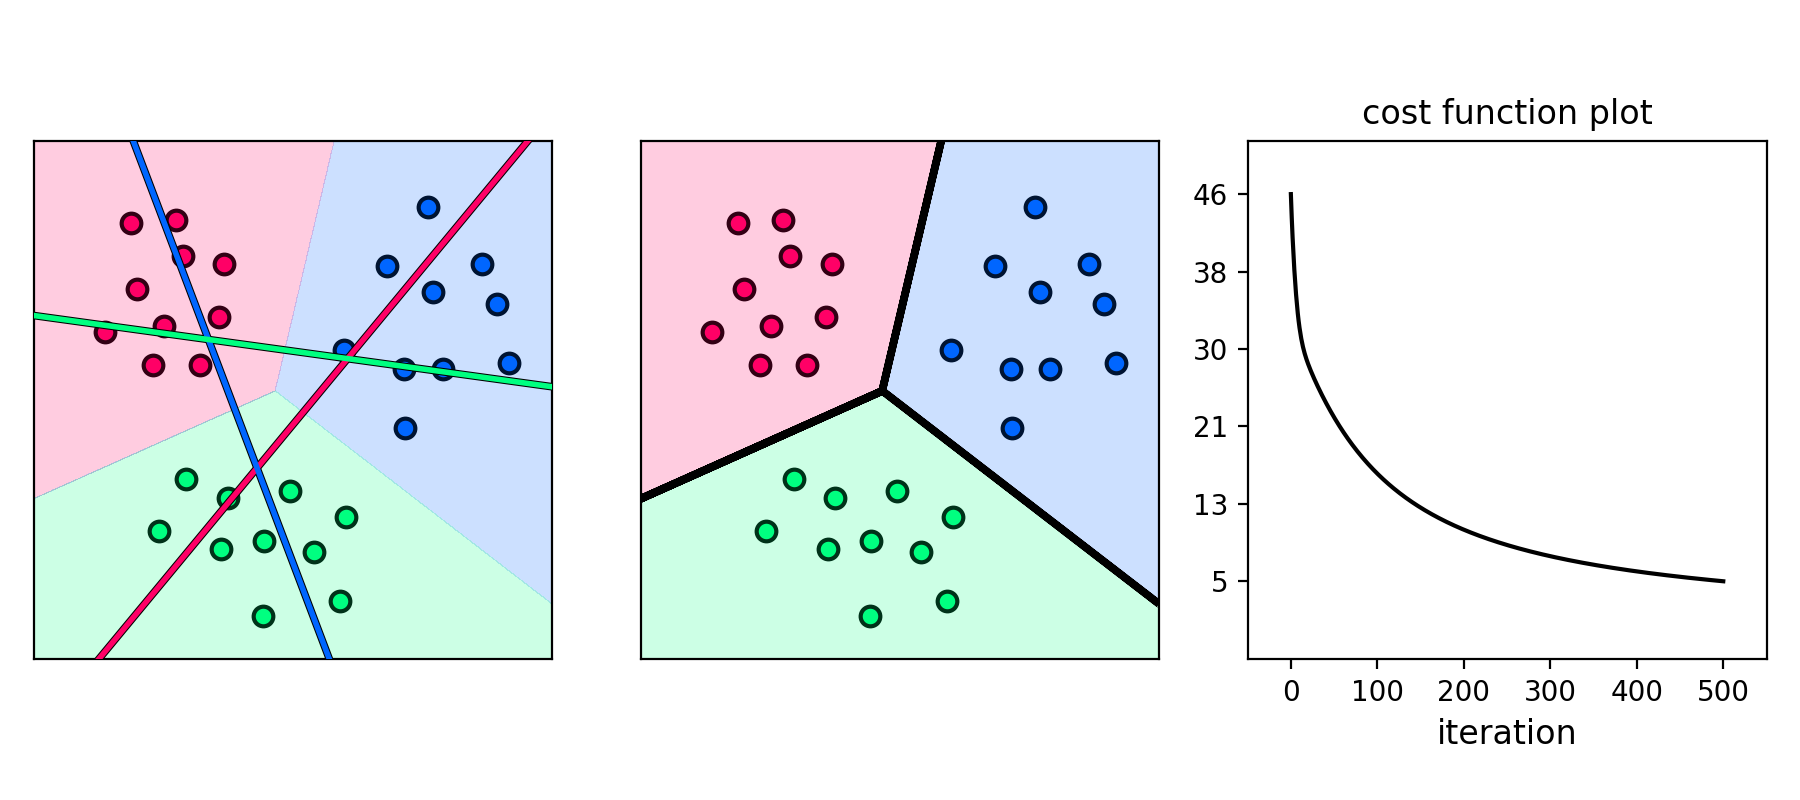

In [35]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(w_hist,show_cost = True, cost = multiclass_softmax)

Optimizing using Newton's method takes just a few steps: in the next cell we re-run the above experiment only using 5 Newton steps.

In [14]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,3)
w_hist = opt.newtons_method(g = multiclass_softmax,w = W_init,max_its = 5)

Below we then print out the same panels as previously, only displaying the results of Newton's method.  Using just a few steps we reach a far lower point on the multi-class softmax function - as can be seen by comparing the right panel below with the one shown previously with gradient descent.

### Newton's method

<IPython.core.display.Javascript object>


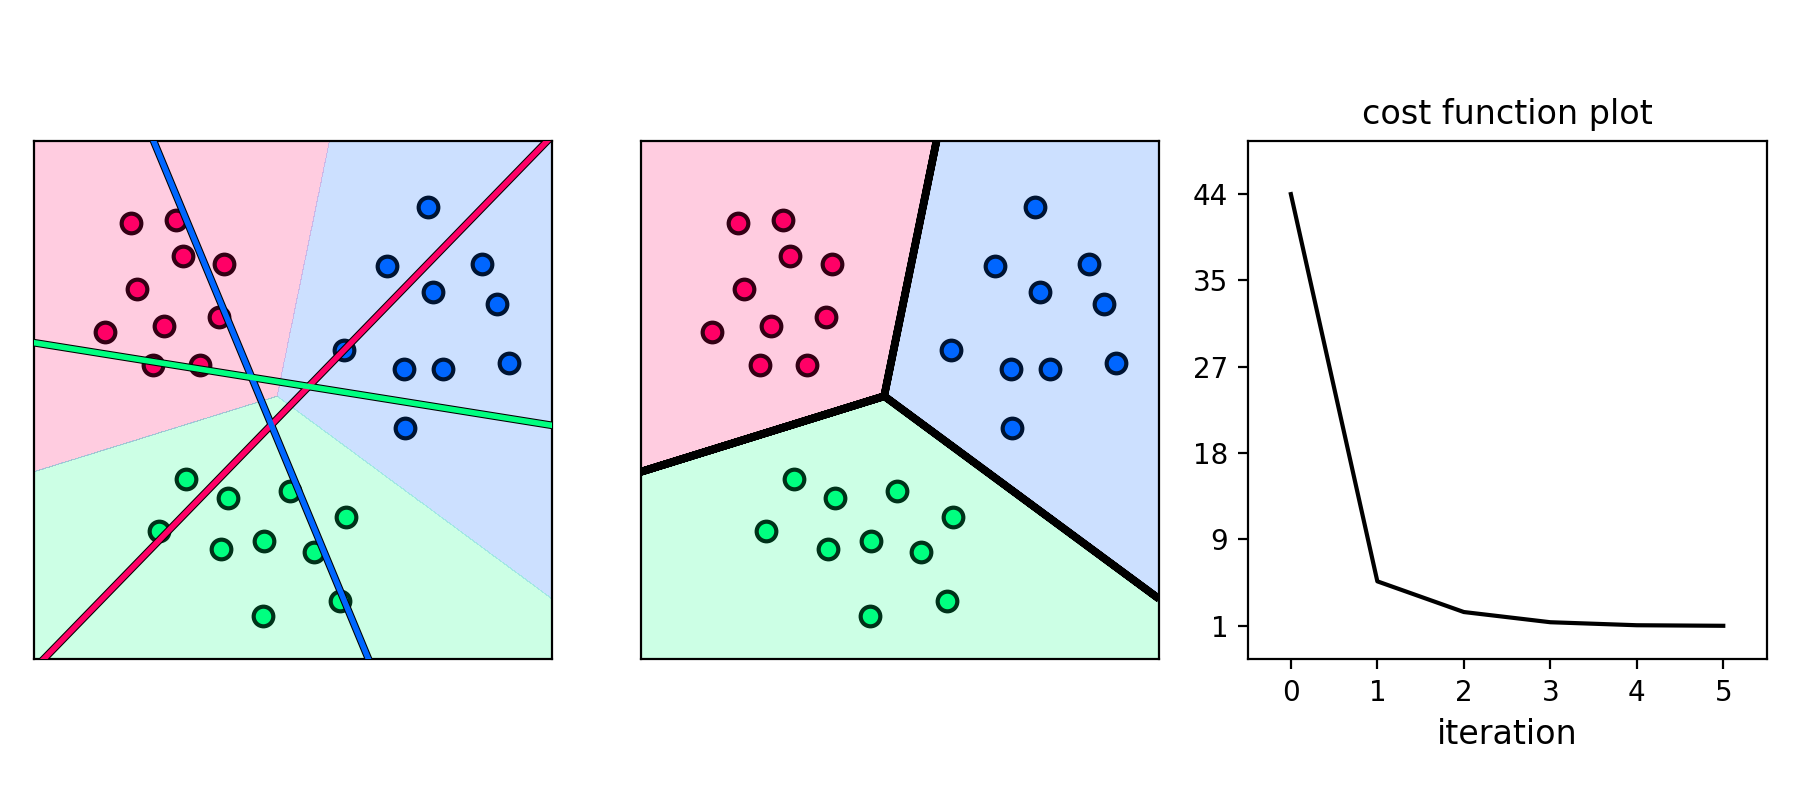

In [15]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(w_hist,show_cost = True, cost = multiclass_softmax)

#### <span style="color:#a50e3e;">Example 3: </span> Multi-class classification from a regression perspective

As we saw previously in our post on logistic regression, two-class classification can be viewed from two different but equally important perspectives. The first perspective is one of regression or surface fitting where by keeping the label dimension we fit a step-like function to the data in the problem's input-output space. A second perspective on classification is when we discard the label dimension and try to separate out the points solely in their input space. The latter, which we called the perceptron view, is what we have adopted so far to study multi-class classification.

It should come as little surprise that one can also view multi-class classification from a regression (or surface fitting) perspective - only this time the step-like function to be fit to the data has more than two levels or steps, each defining one of the classes. In the Python cell below we show both perspectives side-by-side using our toy $C=3$ class dataset.

<IPython.core.display.Javascript object>


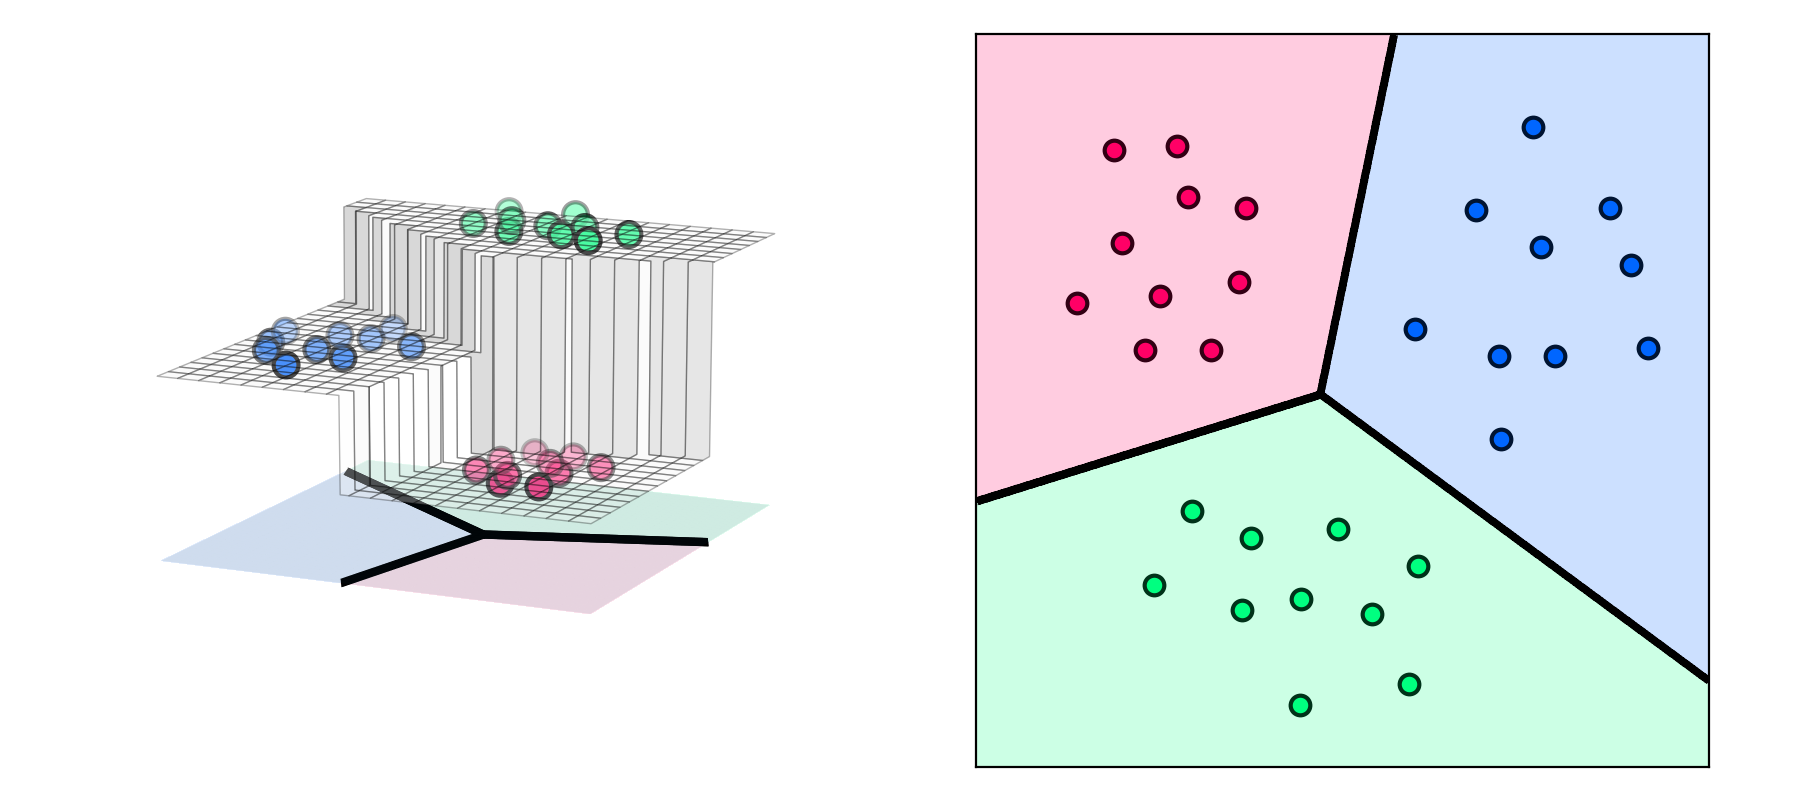

In [16]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_surface_fit(w_hist,view = [15,115])

#### <span style="color:#a50e3e;">Example 4: </span> Multi-class softmax on a toy dataset with $C = 4$ classes

Here we apply Newton's method to fit the multi-class softmax cost to our toy dataset with $C=4$ classes.

<IPython.core.display.Javascript object>


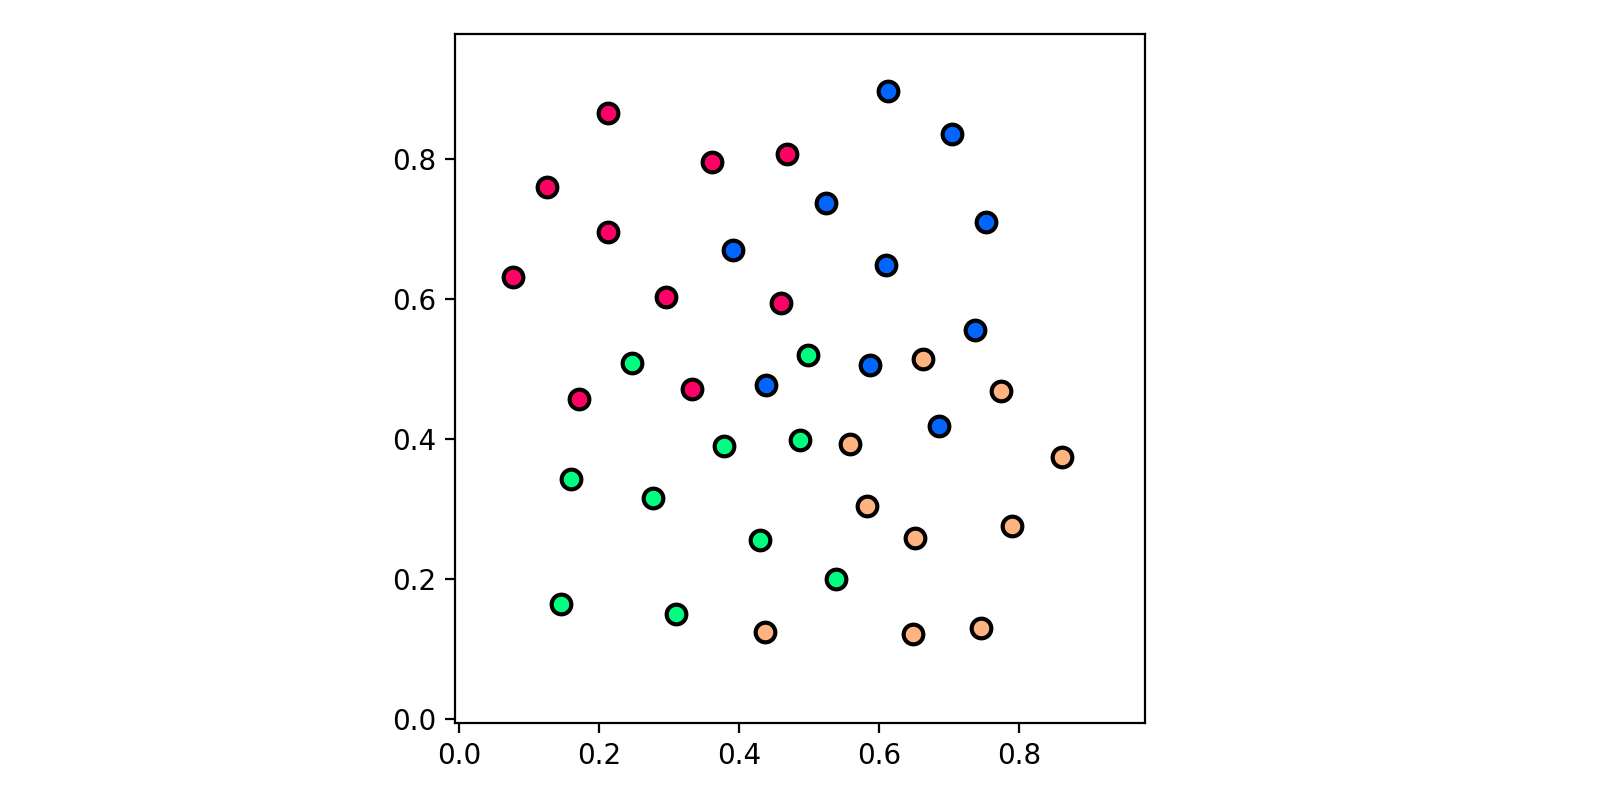

In [10]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/4class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

In [11]:
# define the input and output of our dataset
x = np.asarray(data[:,:-1])
x.shape = (len(x),np.shape(data)[1]-1); x = x.T;
y = data[:,-1]
y.shape = (len(y),1)

In the next cell we run Newton's method for 5 iterations.

In [16]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,4)
w_hist = opt.newtons_method(g = multiclass_softmax,w = W_init,max_its = 5)

Finally, we plot our results, as in the previous Example.

<IPython.core.display.Javascript object>


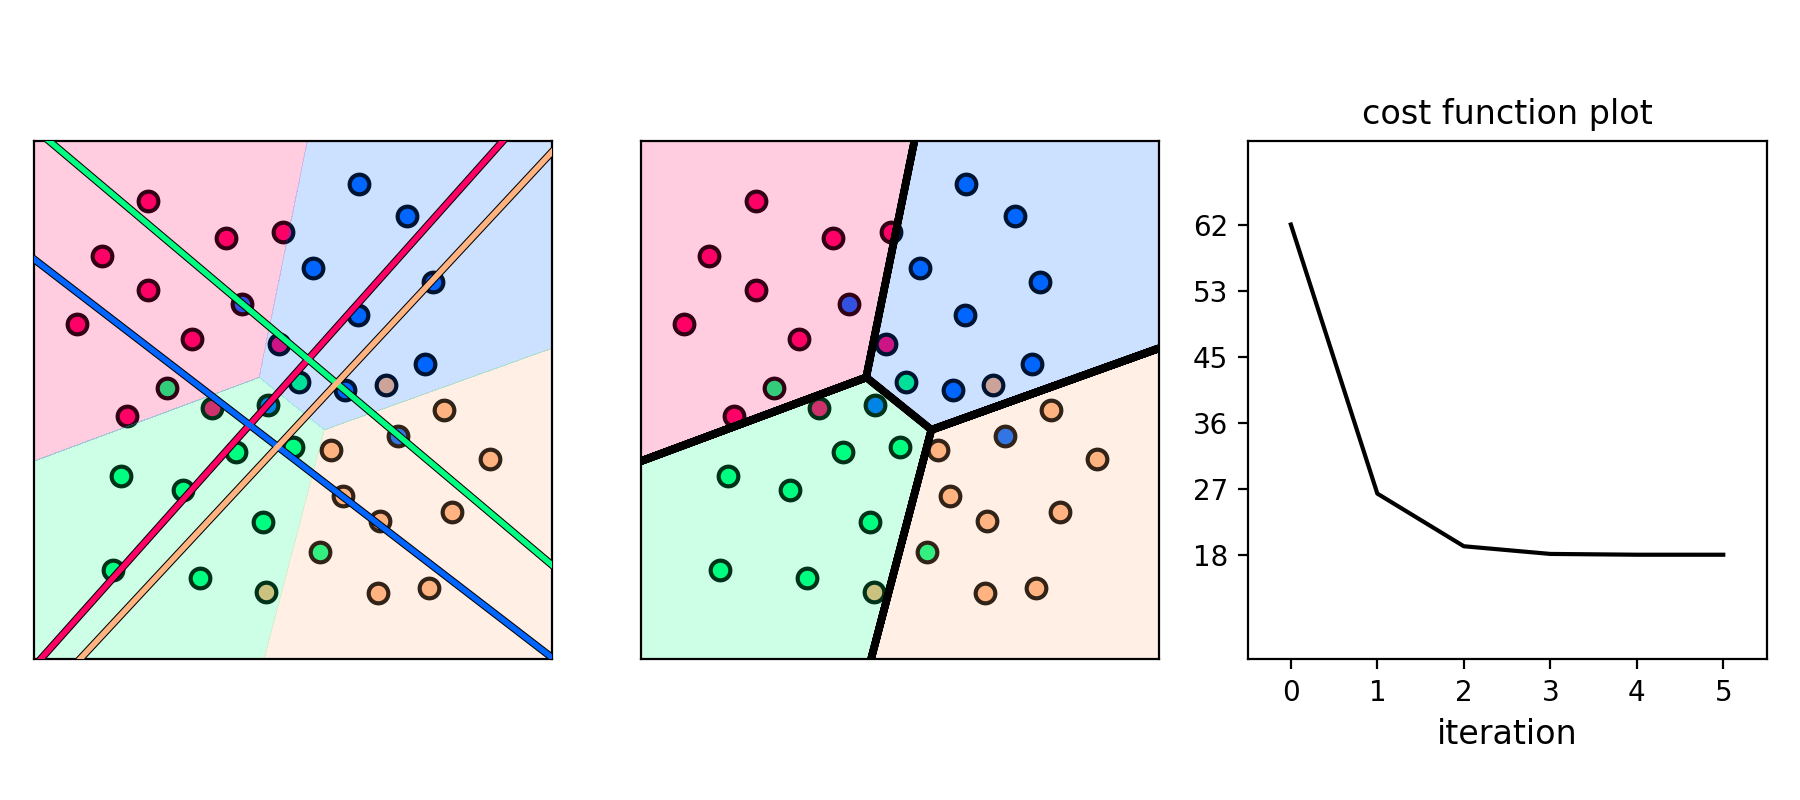

In [17]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(w_hist,show_cost = True, cost = multiclass_softmax)

#### <span style="color:#a50e3e;">Example 5: </span> Comparing cost function and counting cost values

Below we compare the number of misclassifications versus the multi-class softmax cost with regularizer. In this instance $\lambda = 10^{-3}$ for three runs of unnormalized gradient descent using a steplength parameter $\alpha = 10^{-2}$ for all three runs.

<IPython.core.display.Javascript object>


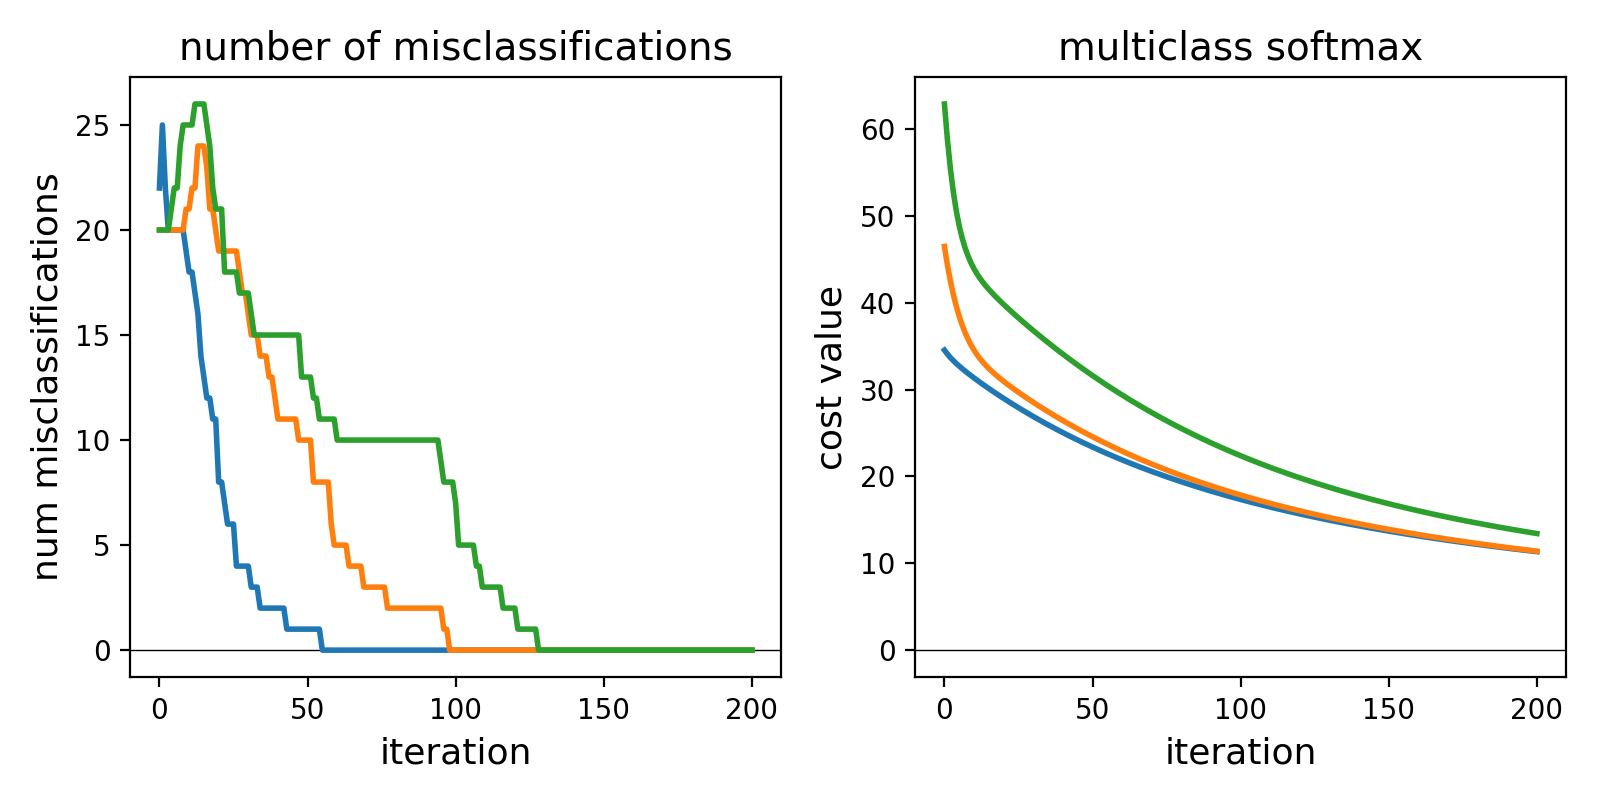

In [18]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# run demo
demo.compare_to_counting(num_runs = 3)

## 1.4  Counting misclassifications and the accuracy of a multi-class classifier

Similar to OvA! Once trained we can compute predicted labels for our training set by simply evaluating each input via the fusion rule. 

\begin{equation}
\hat y_p =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}
\end{equation}

\begin{equation}
\text{number of misclassifications on training set } = \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right |
\end{equation}

\begin{equation}
\text{accuracy of learned classifier} = 1 - \frac{1}{P} \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right |
\end{equation}

## 1.5 Multi-class softmax from a probabilistic perspective

Similarly to the two-class case, the data independence assumption allows us to simplify the joint likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},\mathbf{W}\right)
\end{equation} 

where 

\begin{equation}
\mathbf{W}=\left[\begin{array}{cccc}
w_{0}^{(1)} & w_{0}^{(2)} & \cdots & w_{0}^{(C)}\\
\mathbf{w}^{(1)} & \mathbf{w}^{(2)} & \cdots & \mathbf{w}^{(C)}
\end{array}\right]
\end{equation}

We again connect the probability of a point $\mathbf{x}_p$ belonging to a certain class to the *signed* distance from $\mathbf{x}_p$ to that class' decision boundary.

Assuming all classifiers' normal vectors are normalized to have unit length

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto w_0^{(1)}+\mathbf{x}_p^T\mathbf{w}^{(1)}\\
{\cal P}\left(y=2\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto w_0^{(2)}+\mathbf{x}_p^T\mathbf{w}^{(2)}\\
\vdots\\
{\cal P}\left(y=C\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto w_0^{(C)}+\mathbf{x}_p^T\mathbf{w}^{(C)}
\end{equation} 

These signed distances however can be negative and hence cannot be used immediately as class probabilities.

We can resolve this issue by passing them through an always-positive and monotonically-increasing function such as $e^{\left(\cdot \right)}$ to get

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto e^{w_0^{(1)}+\mathbf{x}_p^T\mathbf{w}^{(1)}}\\
{\cal P}\left(y=2\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto e^{w_0^{(2)}+\mathbf{x}_p^T\mathbf{w}^{(2)}}\\
\vdots\\
{\cal P}\left(y=C\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto e^{w_0^{(C)}+\mathbf{x}_p^T\mathbf{w}^{(C)}}
\end{equation} 

One issue still remains and that is $e^{w_0^{(c)}+\mathbf{x}_p^T\mathbf{w}^{(c)}}$ can potentially be larger than one and hence not a valid probability.


Luckily there is a simple fix for this issue as well: divide all values by $\sum_{j=1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}$


\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},\mathbf{W}\right) \propto \frac{e^{w_0^{(1)}+\mathbf{x}_p^T\mathbf{w}^{(1)}}}{\sum_{j=1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}\\
{\cal P}\left(y=2\,|\,\mathbf{x}_{p},\mathbf{W}\right) \propto \frac{e^{w_0^{(2)}+\mathbf{x}_p^T\mathbf{w}^{(2)}}}{\sum_{j=1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}\\
\vdots\\
{\cal P}\left(y=C\,|\,\mathbf{x}_{p},\mathbf{W}\right)\propto \frac{e^{w_0^{(C)}+\mathbf{x}_p^T\mathbf{w}^{(C)}}}{\sum_{j=1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}
\end{equation} 

Notice that all right hand side values now lie between $0$ and $1$, and moreover, they all add up to $1$ making them mathematically valid values to represent the class probabilities. 

Plugging   

\begin{equation} 
{\cal P}\left(y=y_p\,|\,\mathbf{x}_{p},\mathbf{W}\right) = \frac{e^{w_0^{(y_p)}+\mathbf{x}_p^T\mathbf{w}^{(y_p)}}}{\sum_{j=1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}}}
\end{equation} 

into 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},\mathbf{W}\right)
\end{equation} 

and taking the negative logarithm of the resulting function gives the multi-class negative log-likelihood loss 

\begin{equation}
g\left(\mathbf{W} \right) = -\sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }{ \sum_{j = 1}^{C}  e^{ w_0^{(j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(j)}} }\right)
\end{equation}

This is precisely the multi-class softmax cost we derived previously! 

## 1.6 Which multi-class classification scheme works best?

- One-versus-all (OvA) and multi-class softmax classifiers perform similarly well in practice, having both been built using the same fusion rule.

- The OvA classifier is naturally parallelizable, as each linear separator can be learned independently of the rest.

- The multi-class softmax scheme provides a more commonly used framework for performing nonlinear multi-class classification using neural networks.

# Appendix

## Multi-class perceptron reduces to two-class perceptron when $C = 2$

When $C=2$ the multi-class perceptron cost in equation (4) reduces to 

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)} \right) = \sum_{p = 1}^P \left[\,{\text{max}} \left(w_0^{(1)} + \mathbf{x}_{p}^T\mathbf{w}^{(1)},\,w_0^{(2)} + \mathbf{x}_{p}^T\mathbf{w}^{(2)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]
\end{equation}

which, using the following equality for any real values $a$, $b$, and $c$   

\begin{equation}
{\text{max}} \left(a,b\right) - c = {\text{max}} \left(a-c,b-c\right)
\end{equation}

can be written equivalently as 



\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)} \right) = \sum_{p = 1}^P {\text{max}} \left(w_0^{(1)} + \mathbf{x}_{p}^T\mathbf{w}^{(1)}- \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}^{(y_p)}\right), \,w_0^{(2)} + \mathbf{x}_{p}^T\mathbf{w}^{(2)}- \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}^{(y_p)}\right)\right) 
\end{equation}

Grouping the summands according to their labels, we have 

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)} \right) = \sum_{p:\, y_p = 1} {\text{max}} \left(0, \,w_0^{(2)}-w_0^{(1)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(2)}-\mathbf{w}^{(1)}\right)\right)\\
+ \sum_{p:\, y_p = 2} {\text{max}} \left(0, \,w_0^{(1)}-w_0^{(2)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(1)}-\mathbf{w}^{(2)}\right)\right)
\end{equation}

Re-assigning the labels $y_p=1 \rightarrow y_p=-1$ and $y_p=2 \rightarrow y_p=+1$ to match the label values we used in deriving the two-class perceptron, we can write

\begin{equation}
g\left(w_0^{(-1)},\,\mathbf{w}_{\mathstrut}^{(-1)},\,w_0^{(+1)},\,\mathbf{w}_{\mathstrut}^{(+1)} \right) = \sum_{p:\, y_p = -1} {\text{max}} \left(0, \,w_0^{(+1)}-w_0^{(-1)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}\right)\right) \\+ \sum_{p:\, y_p = +1} {\text{max}} \left(0, \,w_0^{(-1)}-w_0^{(+1)} + \mathbf{x}_{p}^T\left(\mathbf{w}^{(-1)}-\mathbf{w}^{(+1)}\right)\right)
\end{equation}

Letting $w_0=w_0^{(+1)}-w_0^{(-1)}$ and $\mathbf{w}=\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}$, the above can be written as  

\begin{equation}
g\left(w_0,\mathbf{w} \right) = \sum_{p:\, y_p = -1} {\text{max}} \left(0, \,w_0 + \mathbf{x}_{p}^T\mathbf{w}\right) + \sum_{p:\, y_p = +1} {\text{max}} \left(0, \,-w_0 - \mathbf{x}_{p}^T\mathbf{w}\right)
\end{equation}

This can be written more compactly to arrive at the familiar two-class perceptron cost function

\begin{equation}
g\left(w_0,\mathbf{w} \right) = \sum_{p=1}^P {\text{max}} \left(0, -y_p\left(w_0 + \mathbf{x}_{p}^T\mathbf{w}\right)\right) 
\end{equation}

## Multi-class logistic regression reduces to two-class logistic regression when $C = 2$

When $C=2$ the multi-class softmax cost in equation (12) reduces to 

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)} \right) = \sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(1)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(1)}} +e^{ w_0^{(2)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(2)}}  }{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }\right)
\end{equation}

Grouping the summands according to their labels, we have 

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)} \right) = \sum_{p:\, y_p = 1} \text{log}\left( 1 + e^{w_0^{(2)}-w_0^{(1)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(2)}-\mathbf{w}^{(1)}\right)} \right) \\+ \sum_{p:\, y_p = 2} \text{log}\left( 1 + e^{w_0^{(1)}-w_0^{(2)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(1)}-\mathbf{w}^{(2)}\right)} \right) 
\end{equation}

Re-assigning the labels $y_p=1 \rightarrow y_p=-1$ and $y_p=2 \rightarrow y_p=+1$ to match the label values we used in deriving the two-class softmax cost previously, we can write

\begin{equation}
g\left(w_0^{(-1)},\,\mathbf{w}^{(-1)},\,w_0^{(+1)},\,\mathbf{w}_{\mathstrut}^{(+1)} \right)  = \sum_{p:\, y_p = -1} \text{log}\left( 1 + e^{w_0^{(+1)}-w_0^{(-1)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}\right)} \right) \\+ \sum_{p:\, y_p = +1} \text{log}\left( 1 + e^{w_0^{(-1)}-w_0^{(+1)} + \mathbf{x}_{p}^T \left(\mathbf{w}^{(-1)}-\mathbf{w}^{(+1)}\right)} \right) 
\end{equation}

Letting $w_0=w_0^{(+1)}-w_0^{(-1)}$ and $\mathbf{w}=\mathbf{w}^{(+1)}-\mathbf{w}^{(-1)}$, the above can be written as  

\begin{equation}
g\left(w_0,\mathbf{w} \right)  = \sum_{p:\, y_p = -1} \text{log}\left( 1 + e^{w_0 + \mathbf{x}_{p}^T\mathbf{w}} \right) + \sum_{p:\, y_p = +1} \text{log}\left( 1 + e^{-w_0 - \mathbf{x}_{p}^T \mathbf{w}} \right) 
\end{equation}

This can be written more compactly to arrive at the familiar two-class softmax cost function

\begin{equation}
g\left(w_0,\mathbf{w} \right) = \underset{p=1}{\overset{P}{\sum}}\mbox{log}\left(1+e^{-y_{p}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}\right)}\right)
\end{equation}

## Multi-class perceptron and softmax costs are convex

Notice we always have that:
    
**I.** Addition of two (or more) convex functions is always convex.

**II.** Linear and affine functions are convex.

**III.** The max, exponential, and negative logarithm functions are all convex.

**IV.** Composition of two convex functions remains convex.

Each of the statements above can be verified easily using the following definition of convexity:

A function g is convex if and only if for all $\mathbf{w}_1$ and $\mathbf{w}_2$ in the domain of g and all $\lambda \in \left[0, 1\right]$, we have

\begin{equation}
g\left(\lambda \mathbf{w}_1+\left(1-\lambda\right) \mathbf{w}_2\right)\leq \lambda g\left(\mathbf{w}_1\right)+\left(1-\lambda\right) g\left(\mathbf{w}_2\right)
\end{equation}


With these four statements at hand, it is straight-forward to prove convexity of multi-class perceptron and softmax cost functions. 